In [79]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sb

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import os

import tensorflow as tf
from tensorflow import keras
import numpy as np


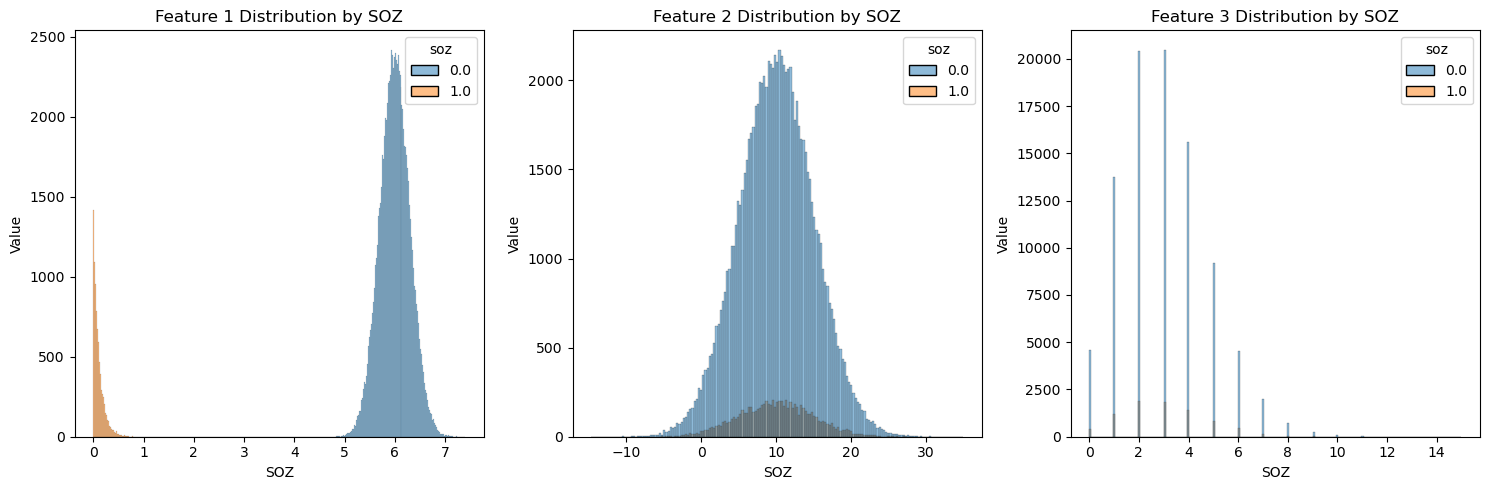

Examples:
    Total: 100000
    Positive: 8333 (8.33% of total)



In [80]:
def attention_fakedata():
    rng = np.random.default_rng(42)
    ratio = 11.0

    # Generate synthetic data with 
    n_samples = 100000
    n_pos = int(n_samples / (ratio + 1))  # Calculate number of positive samples
    n_neg = n_samples - n_pos  # Remaining are negative samples

    # Create labels array with the correct ratio
    labels = np.concatenate([np.zeros(n_neg), np.ones(n_pos)])

    # Shuffle the labels
    rng.shuffle(labels)

    # Create a DataFrame with the synthetic data
    raw_df = pd.DataFrame({'soz': labels})

    # Using boolean indexing:
    mask0 = raw_df['soz'] == 0
    mask1 = raw_df['soz'] == 1

    raw_df.loc[mask0, 'f1'] = rng.normal(6, 0.3, size=mask0.sum())
    raw_df.loc[mask1, 'f1'] = rng.gamma(1, .11, size=mask1.sum())


    raw_df['f2'] = rng.normal(10, 5, size=n_samples)
    raw_df['f3'] = rng.poisson(lam=3, size=n_samples)

    # plot features on one 1,3 plot grouped by soz
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot feature 1 distributions
    sb.histplot(data=raw_df, hue='soz', x='f1', ax=axes[0])
    axes[0].set_title('Feature 1 Distribution by SOZ')
    axes[0].set_xlabel('SOZ')
    axes[0].set_ylabel('Value')

    # Plot feature 2 distributions  
    sb.histplot(data=raw_df, hue='soz', x='f2', ax=axes[1])
    axes[1].set_title('Feature 2 Distribution by SOZ')
    axes[1].set_xlabel('SOZ')
    axes[1].set_ylabel('Value')

    # Plot feature 3 distributions
    sb.histplot(data=raw_df, hue='soz', x='f3', ax=axes[2])
    axes[2].set_title('Feature 3 Distribution by SOZ')
    axes[2].set_xlabel('SOZ')
    axes[2].set_ylabel('Value')

    plt.tight_layout()
    plt.show()

    neg, pos = np.bincount(raw_df['soz'])
    total = neg + pos
    print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
        total, pos, 100 * pos / total))

    initial_bias = np.log([pos/neg])
    return raw_df,initial_bias

raw_df, initial_bias = attention_fakedata()

In [81]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(raw_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('soz')).reshape(-1, 1)
bool_train_labels = train_labels[:, 0] != 0
val_labels = np.array(val_df.pop('soz')).reshape(-1, 1)
test_labels = np.array(test_df.pop('soz')).reshape(-1, 1)

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

# train_features = np.clip(train_features, -5, 5)
# val_features = np.clip(val_features, -5, 5)
# test_features = np.clip(test_features, -5, 5)

In [82]:
METRICS = [
    keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
    keras.metrics.MeanSquaredError(name='Brier score'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def early_stopping():
 return tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


In [83]:
N_value = train_df.shape[1]
inputs = keras.Input(shape=(N_value,))

# Reshape to (batch, N, 1) to treat each feature as a token.
x = keras.layers.Reshape((N_value, 1))(inputs)

# Self-attention block:
# Using one head with key_dim=1 so that the attention scores have shape (batch, 1, N, N)
attn_layer = keras.layers.MultiHeadAttention(num_heads=1,key_dim=8)
# We set return_attention_scores=True to obtain the attention matrix.
output_tensor, attn_scores = attn_layer(x, x, return_attention_scores=True)
# Remove the head dimension so attn_scores becomes (batch, N, N)
# attn_scores = keras.layers.Lambda(lambda t: tf.squeeze(t, axis=1))(attn_scores)
x = keras.layers.Flatten()(output_tensor)

# Apply layer normalization to the attention matrix.
x = keras.layers.LayerNormalization()(x)

# MLP block:
x = keras.layers.Dense(4 * N_value, activation='relu')(x)
# x = keras.layers.Dense(2 * N_value, activation='relu')(x)
# x = keras.layers.Dense(N_value, activation='relu')(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS
)

In [84]:
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 3, 1)      │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ [(None, 3, 1),    │         57 │ reshape_7[0][0],  │
│ (MultiHeadAttentio… │ (None, 1, 3, 3)]  │            │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 3)         │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3)         │          6 │ flatten_7[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 12)        │         48 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │         13 │ dense_14[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 124 (496.00 B)

 Trainable params: 124 (496.00 B)

 Non-trainable params: 0 (0.00 B)

In [85]:
from tensorflow.python.client import device_lib
from tensorflow.keras.callbacks import TensorBoard

# file_name = "attention_model"
# tensorboard = TensorBoard(log_dir=f"logs/{file_name}")
# !mkdir -p logs

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


I0000 00:00:1743092344.381966   94058 gpu_device.cc:2018] Created device /device:GPU:0 with 3727 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:21:00.0, compute capability: 7.5


In [86]:
EPOCHS = 200
BATCH_SIZE = 2048

history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels),
    verbose=1,
    callbacks=[early_stopping()])

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - Brier score: 0.2463 - accuracy: 0.7230 - auc: 0.6334 - cross entropy: 0.6858 - fn: 849.6061 - fp: 6460.0908 - loss: 0.6858 - prc: 0.2215 - precision: 0.2032 - recall: 0.6092 - tn: 25303.9395 - tp: 2047.2122 - val_Brier score: 0.2211 - val_accuracy: 0.9320 - val_auc: 0.9633 - val_cross entropy: 0.6352 - val_fn: 546.0000 - val_fp: 542.0000 - val_loss: 0.6352 - val_prc: 0.5240 - val_precision: 0.5785 - val_recall: 0.5767 - val_tn: 14168.0000 - val_tp: 744.0000
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Brier score: 0.2122 - accuracy: 0.9368 - auc: 0.9670 - cross entropy: 0.6172 - fn: 647.5455 - fp: 1515.4242 - loss: 0.6172 - prc: 0.5658 - precision: 0.6023 - recall: 0.7293 - tn: 30237.3945 - tp: 2260.4849 - val_Brier score: 0.1838 - val_accuracy: 0.9364 - val_auc: 0.9768 - val_cross entropy: 0.5590 - val_fn: 53.0000 - val_fp: 965.0000 - val_loss: 0.5590 - val_prc: 0.6529 - val_precision: 0.5618 - val_recall: 0.9589 - val_tn:

Text(0.5, 0.98, 'Attention Scores | 1.00')

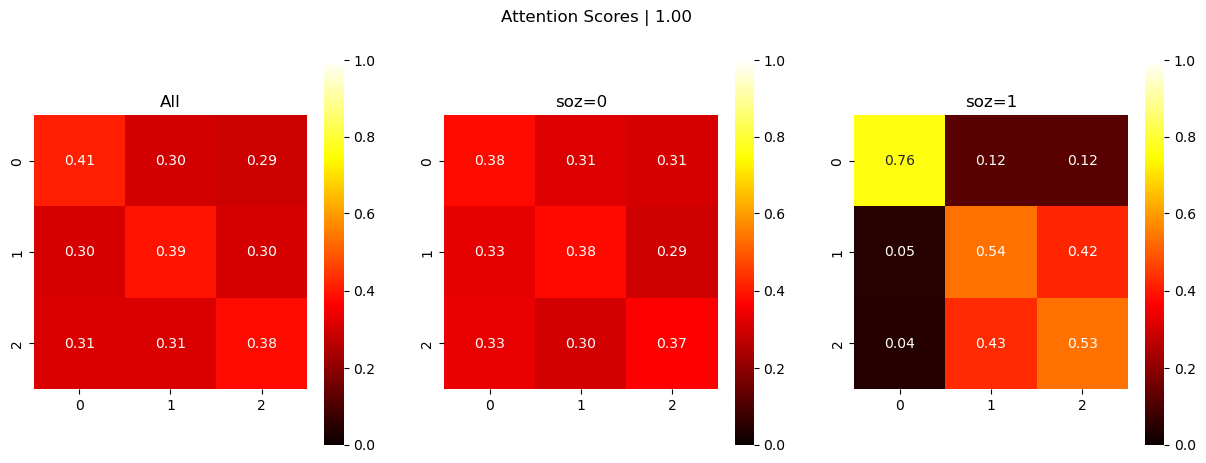

In [87]:
attn = model.layers[2]
x = train_features.reshape(-1, train_features.shape[-1], 1)
_, attention_scores = attn(x,x, return_attention_scores=True) # take one sample


mean_all = attention_scores.numpy().squeeze().mean(axis=0)
mean_0 = attention_scores.numpy()[train_labels[:,0]==0,0,:,:].squeeze().mean(axis=0)
mean_1 = attention_scores.numpy()[train_labels[:,0]==1,0,:,:].squeeze().mean(axis=0)

fig,axes = plt.subplots(1,3,figsize=(15,5))
sb.heatmap(mean_all, annot=True, cbar=True,square=True, fmt='.2f', ax=axes[0], cmap='hot',vmin=0,vmax=1)
sb.heatmap(mean_0, annot=True, cbar=True,square=True, fmt='.2f', ax=axes[1], cmap='hot',vmin=0,vmax=1)
sb.heatmap(mean_1, annot=True, cbar=True,square=True, fmt='.2f', ax=axes[2], cmap='hot',vmin=0,vmax=1)
axes[0].set_title('All')
axes[1].set_title('soz=0')
axes[2].set_title('soz=1')
plt.suptitle(f'Attention Scores | {history.history["prc"][-1]:.2f}')



In [44]:
attention_scores[0,0,:,:].numpy().sum(axis=1)

array([1.        , 1.        , 1.        , 0.9999999 , 1.0000001 ,
       1.        , 1.        , 1.0000001 , 0.9999999 , 1.        ,
       1.        , 1.        , 1.        , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99999994, 1.        , 0.99999994, 1.        ,
       1.0000001 , 0.9999999 , 0.99999994, 0.99999994, 0.99999994,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 0.99999994, 1.        , 1.        , 1.        ,
       1.0000001 , 1.        , 1.        , 1.        , 1.0000001 ,
       1.        , 1.0000001 , 1.        , 0.99999994, 1.0000001 ,
       1.        , 1.        , 0.99999994, 0.99999994], dtype=float32)